In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataprep.eda import plot
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.metrics import log_loss, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from collections import Counter
from utils import *

NumExpr defaulting to 4 threads.


Using TensorFlow backend.


In [39]:

table = pd.read_csv('17features.csv')

admission = pd.read_csv("mimic/ADMISSIONS.csv")
patient = pd.read_csv('mimic/PATIENTS.csv')
diagnoses = pd.read_csv('mimic/DIAGNOSES_ICD.csv')
admission['LOS'] = (pd.to_datetime(admission['DISCHTIME']) - pd.to_datetime(admission['ADMITTIME'])).dt.total_seconds()/86400
admission = admission[admission['LOS']>0]
admission = admission.merge(patient, on='SUBJECT_ID')
admission['age'] = calculate_age(admission, 'ADMITTIME', 'DOB')
admission = admission[admission['age']>=15]
admission['GENDER'] = admission['GENDER'].apply(lambda x: 1 if x=='M' else 0)
diagnoses['disease'] = diagnoses['ICD9_CODE'].apply(lambda x: D_Category[assign_category(x)])
diagnoses = diagnoses[['HADM_ID', 'disease']]
diag_oh = pd.get_dummies(diagnoses, columns=['disease'])
diag_oh = diag_oh.groupby('HADM_ID').sum()


admission = admission[['HADM_ID', 'ADMISSION_TYPE', 'GENDER', 'age', 'LOS']]
admission = admission.merge(diag_oh, on='HADM_ID')
admission

,HADM_ID,ADMISSION_TYPE,GENDER,age,LOS,disease_certain conditions originating in the perinatal period,"disease_complications of pregnancy, childbirth, and the puerperium",disease_congenital anomalies,disease_diseases of the blood and blood-forming organs,disease_diseases of the circulatory system,...,disease_diseases of the nervous system and sense organs,disease_diseases of the respiratory system,disease_diseases of the skin and subcutaneous tissue,"disease_endocrine, nutritional and metabolic diseases, and immunity disorders",disease_external causes of injury and supplemental classification,disease_infectious and parasitic diseases,disease_injury and poisoning,disease_mental disorders,disease_neoplasms,"disease_symptoms, signs, and ill-defined conditions"
0,165315,EMERGENCY,0,65,1.144444,0,0,0,0,1,...,1,0,0,0,2,0,2,1,0,0
1,152223,ELECTIVE,1,71,5.496528,0,0,0,0,4,...,1,0,0,1,1,0,0,0,0,0
2,124321,EMERGENCY,1,75,6.768056,0,0,0,0,2,...,1,0,0,2,3,0,0,0,1,1
3,161859,EMERGENCY,1,39,2.856944,0,0,0,0,2,...,0,0,0,1,0,0,0,0,0,0
4,129635,EMERGENCY,1,59,3.534028,0,0,0,0,3,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50772,190603,ELECTIVE,1,78,4.145833,0,0,0,0,1,...,1,0,0,0,3,0,0,0,0,0
50773,105447,EMERGENCY,1,88,0.662500,0,0,0,0,1,...,3,1,0,1,1,0,1,0,0,0
50774,191113,EMERGENCY,0,20,2.742361,0,0,0,1,0,...,0,0,0,0,1,0,5,0,0,0
50775,101071,EMERGENCY,0,84,0.548611,0,0,0,0,3,...,0,0,0,0,1,0,0,0,0,0


# LOS Prediction

In [40]:


# y = data['LOS'].to_frame()
# X = data.drop(['LOS', 'Unnamed: 0', 'HADM_ID'], axis=1)

# X = pd.get_dummies(X, columns=['ADMISSION_TYPE'])

# feature_names = X.columns.values.tolist()
# # for i in range(len(feature_names)):
# #     feature_names[i] = 'item_'+feature_names[i]
# y
# import random
# # data = table.merge(admission[['HADM_ID', 'LOS', 'age', 'ADMISSION_TYPE', 'GENDER']].reset_index(), on='HADM_ID')
data = table.merge(admission, on='HADM_ID')

data = pd.get_dummies(data, columns=['ADMISSION_TYPE'])
# # data = data.drop(['Unnamed: 0', 'HADM_ID', 'index'], axis=1)
data = data.drop(['HADM_ID', 'Unnamed: 0'], axis=1)
data['y'] = data['LOS'].apply(lambda x: 0 if x<5 else 1)
label_0 = data[data['y']==0]
label_1 = data[data['y']==1]
base_num = min(len(label_0), len(label_1))
label_1 = label_1.sample(n=base_num, random_state=2)
data = pd.concat([label_0, label_1])
y = data['y']
X = data.drop(['LOS', 'y'], axis=1)
# y1 = data['LOS']
# X1 = data.drop(['LOS'], axis=1)
# data['y1'] = data['LOS'].apply(lambda x: assign_label(x))
# y1 = data['y1']
# X1 = data.drop(['LOS', 'y1'], axis=1)

# label_0 = data[data['y2']==0]
# label_1 = data[data['y2']==1]
# base_num = min(len(label_0), len(label_1))
# label_1 = label_1.sample(n=base_num+random.randint(-150, 150), random_state=1)
# data2 = pd.concat([label_0, label_1])
# y2 = data2['y2']
# X2 = data2.drop(['LOS', 'y1', 'y2', 'y3'], axis=1)

# label_0 = data[data['y3']==0]
# label_1 = data[data['y3']==1]
# base_num = min(len(label_0), len(label_1))
# label_1 = label_1.sample(n=base_num+random.randint(-200, 200), random_state=1)
# data3 = pd.concat([label_0, label_1])
# y3 = data3['y3']
# X3 = data3.drop(['LOS', 'y1', 'y2', 'y3'], axis=1)
feature_names = X.columns.values.tolist()
X

,gcs_vr,gcs_mr,gcs_eye,bp,hr,temp,fio2,urine,wbc,potassium,...,"disease_endocrine, nutritional and metabolic diseases, and immunity disorders",disease_external causes of injury and supplemental classification,disease_infectious and parasitic diseases,disease_injury and poisoning,disease_mental disorders,disease_neoplasms,"disease_symptoms, signs, and ill-defined conditions",ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT
0,1.0,6.0,3.0,130.000000,85.000000,36.444444,29.816052,160.0,5.1,4.4,...,0,2,0,2,1,0,0,0,1,0
3,5.0,6.0,4.0,144.000000,63.000000,36.166666,29.816052,700.0,9.8,4.1,...,1,0,0,0,0,0,0,0,1,0
4,5.0,6.0,4.0,114.000000,72.000000,36.722221,29.816052,400.0,12.2,3.3,...,1,0,0,0,0,0,0,0,1,0
10,5.0,6.0,4.0,96.000000,100.000000,36.999999,29.816052,500.0,33.5,4.0,...,0,0,0,0,0,0,0,0,1,0
11,5.0,6.0,4.0,153.000000,73.000000,36.277779,1.000000,700.0,11.1,4.1,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46079,5.0,6.0,4.0,129.000000,95.000000,37.277778,29.816052,350.0,23.1,4.7,...,0,1,0,3,0,0,0,0,1,0
14285,1.0,1.0,1.0,127.000000,88.000000,37.388891,29.816052,170.0,9.0,5.9,...,1,0,0,0,0,0,0,0,1,0
19820,1.0,5.0,3.0,130.000000,88.000000,36.888890,1.000000,630.0,11.2,5.5,...,0,2,0,0,0,1,0,0,0,1
5682,5.0,6.0,4.0,130.500897,97.539888,36.702332,29.816052,975.0,8.5,3.9,...,3,6,0,1,1,0,1,0,1,0


In [4]:
# def assign_label(x):
#     if x<3:
#         return 0
#     elif x<7:
#         return 1
#     else:
#         return 2



In [41]:
sc = preprocessing.StandardScaler()
mm = preprocessing.MinMaxScaler()
# X = sc.fit_transform(X)
X = mm.fit_transform(X)

# kb = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
# y1 = kb.fit_transform(y1.to_numpy().reshape(-1, 1))
# y1 = y1.flatten()

X

array([[0.        , 1.        , 0.66666667, ..., 0.        , 1.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.8       , 0.66666667, ..., 0.        , 0.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.6       , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [42]:
# print(kb.bin_edges_)
print(Counter(y))


Counter({0: 17530, 1: 17530})


In [271]:
# # Resampling
# from imblearn.over_sampling import SMOTE

# # setting up testing and training sets
# X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=27)

# sm = SMOTE(random_state=27)
# X_train1, y_train1 = sm.fit_resample(X_train1, y_train1)

In [43]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)


In [8]:
# Baseline 1: Random Forest
rfc = RandomForestClassifier(max_depth=10, random_state=0)
rfc.fit(X_train, y_train)
importance = rfc.feature_importances_


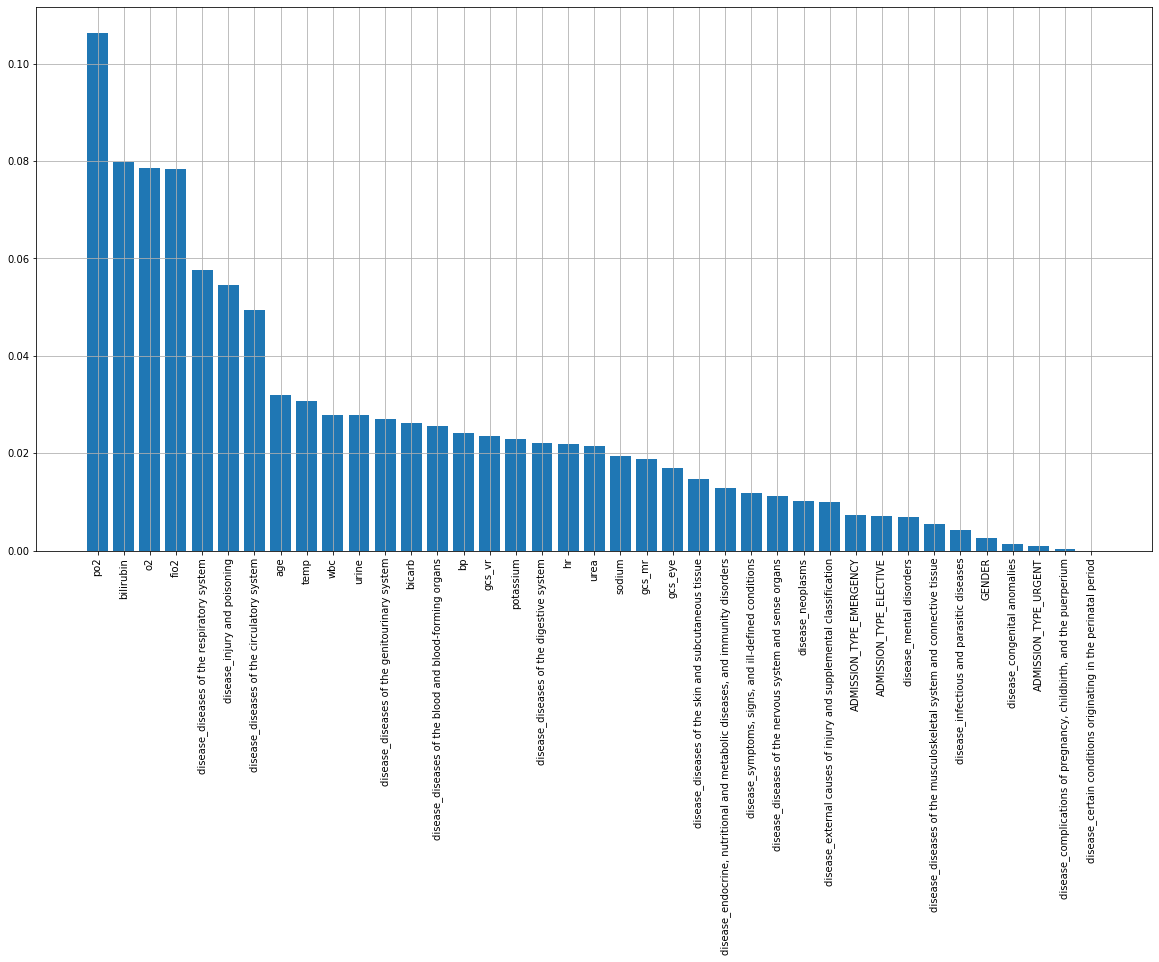

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
a, b = zip(*sorted(zip(importance,feature_names), reverse=True))

ax.bar(b[:50], a[:50])

ax.set_xticklabels(labels = b[:50], rotation=90)
ax.grid()
# fig.savefig('plots/los-fi.png')

In [10]:
rf_score1 = rfc.score(X_test, y_test)
rf_score2 = rfc.score(X_train, y_train)
print(rf_score1)
print(rf_score2)

0.7281802624073017
0.8008770678836281


In [74]:
# Remove features with low importance

# f_names = feature_names.copy()
# def drop_unimportant(X, a, b, feature_names, set_f=0):
#     temp = X.copy()
#     unimp = []
#     for i in range(len(a)):
#         if a[i] < 0.01:
#             unimp.append(b[i])
#             if set_f:
#                 f_names.remove(b[i])
#     index = []
#     for f in unimp:
#         idx = feature_names.index(f)
#         index.append(idx)
#     temp = np.delete(temp, index, axis=1)
#     return temp

# X_train1 = drop_unimportant(X_train1, a, b, feature_names, 1)
# X_test1 = drop_unimportant(X_test1, a, b, feature_names) 
# feature_names = f_names

In [44]:
print(Counter(y_train))
X_train.shape

Counter({1: 14073, 0: 13975})


(28048, 39)

In [95]:
# Baseline 2: sklearn Neural Network
mlp = MLPClassifier().fit(X_train, y_train)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [96]:
nn_score = mlp.score(X_test, y_test)
nn_score2 = mlp.score(X_train, y_train)
print('Test set score: ', nn_score)
print('Training set score', nn_score2)

Test set score:  0.652487516182726
Training set score 0.9059971332131133


In [291]:
# y_train1 = to_categorical(y_train1)
# y_test1 = to_categorical(y_test1)
# X_train1[10]

array([1.        , 1.        , 1.        , 0.5       , 0.33023256,
       0.57692308, 1.        , 0.09589041, 0.00507854, 0.12727273,
       0.02898551, 0.23998044, 0.08185725, 0.04761905, 0.37037037,
       0.64150943, 1.        , 0.42666667, 0.        , 0.        ,
       0.        , 0.125     , 0.05555556, 0.36363636, 0.        ,
       0.        , 0.        , 0.11111111, 0.11111111, 0.        ,
       0.05882353, 0.        , 0.        , 0.09090909, 0.        ,
       0.        , 0.        , 1.        , 0.        ])

Train on 22438 samples, validate on 5610 samples
Epoch 1/100
22438/22438 [==============================] - 1s 60us/step - loss: 0.6237 - accuracy: 0.6509 - val_loss: 0.5940 - val_accuracy: 0.6799
Epoch 2/100
22438/22438 [==============================] - 1s 33us/step - loss: 0.5837 - accuracy: 0.6911 - val_loss: 0.5890 - val_accuracy: 0.6904
Epoch 3/100
22438/22438 [==============================] - 1s 34us/step - loss: 0.5713 - accuracy: 0.7038 - val_loss: 0.5749 - val_accuracy: 0.6993
Epoch 4/100
22438/22438 [==============================] - 1s 34us/step - loss: 0.5643 - accuracy: 0.7090 - val_loss: 0.5799 - val_accuracy: 0.6993
Epoch 5/100
22438/22438 [==============================] - 1s 33us/step - loss: 0.5597 - accuracy: 0.7141 - val_loss: 0.5699 - val_accuracy: 0.7004
Epoch 6/100
22438/22438 [==============================] - 1s 34us/step - loss: 0.5565 - accuracy: 0.7158 - val_loss: 0.5692 - val_accuracy: 0.7043
Epoch 7/100
22438/22438 [==============================] - 1s 3

Epoch 56/100
22438/22438 [==============================] - 1s 34us/step - loss: 0.4988 - accuracy: 0.7553 - val_loss: 0.5508 - val_accuracy: 0.7257
Epoch 57/100
22438/22438 [==============================] - 1s 34us/step - loss: 0.4970 - accuracy: 0.7551 - val_loss: 0.5576 - val_accuracy: 0.7194
Epoch 58/100
22438/22438 [==============================] - 1s 32us/step - loss: 0.4965 - accuracy: 0.7566 - val_loss: 0.5557 - val_accuracy: 0.7196
Epoch 59/100
22438/22438 [==============================] - 1s 32us/step - loss: 0.4945 - accuracy: 0.7571 - val_loss: 0.5529 - val_accuracy: 0.7239
Epoch 60/100
22438/22438 [==============================] - 1s 35us/step - loss: 0.4973 - accuracy: 0.7554 - val_loss: 0.5573 - val_accuracy: 0.7194
Epoch 61/100
22438/22438 [==============================] - 1s 33us/step - loss: 0.4931 - accuracy: 0.7568 - val_loss: 0.5568 - val_accuracy: 0.7184
Epoch 62/100
22438/22438 [==============================] - 1s 39us/step - loss: 0.4934 - accuracy: 0.7580

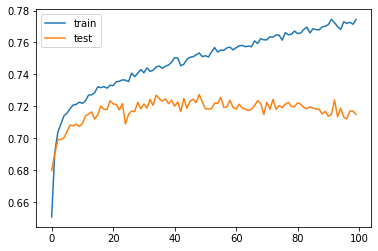

In [45]:
# Neural Network1


def nn(input_dim, output_dim=1, final_act='sigmoid', loss='binary_crossentropy'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim, activation=final_act))

    
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

# l_model = nn(X_train1.shape[1], output_dim=3, final_act='softmax', loss='categorical_crossentropy')
l_model = nn(X_train.shape[1])
nn = l_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=100)
nn_score = l_model.evaluate(X_test, y_test)
nn_score2 = l_model.evaluate(X_train, y_train)
print('Test set score: ', nn_score[1])
print('Training set score', nn_score2[1])
plt.plot(nn.history['accuracy'], label='train')
plt.plot(nn.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [46]:
y_pred = l_model.predict(X_test)

y_pred = np.round(y_pred)
# y_true = np.argmax(y_test, axis=1)

print(Counter(y_test))

cm = confusion_matrix(y_test, y_pred)
cm


Counter({0: 3555, 1: 3457})


array([[2700,  855],
       [1035, 2422]])

In [59]:
# # Single Sample Explainer

# explainer = shap.DeepExplainer(l_model, X_train)
# shap_values = explainer.shap_values(X_test[:2, :])
# explainer.expected_value
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[0])
# predict_fn = lambda x: l_model.predict(x)

array([0.7579103 , 0.19984806, 0.03925155, 0.00299176], dtype=float32)

In [ ]:
# 存档
#     model.add(Dense(39*8, input_dim=X_train.shape[1], kernel_initializer='normal', activation='sigmoid'))
#     model.add(Dropout(0.1))
#     model.add(Dense(39*8, activation='sigmoid'))
#     model.add(Dropout(0.2))

#     model.add(Dense(1, activation=None))
#     model.add(BatchNormalization())
#     model.add(Activation(activation='sigmoid'))

In [33]:
# explaniner = lime.lime_tabular.LimeTabularExplainer(X_train, class_names=['<1', '1-3', '3-7', '>7'], feature_names=feature_names, discretize_continuous=True)

In [47]:
# permutation_importance(l_model, feature_names, X_test, y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/pyt

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/pyt

IndexError: index 0 is out of bounds for axis 0 with size 0

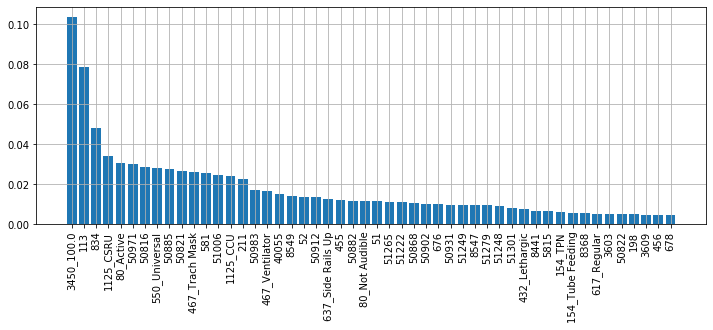

In [176]:

# nn_y = l_model.predict(X_test)
# idx = np.argmax(nn_y, axis=-1)
# nn_y = np.zeros(nn_y.shape)
# nn_y[np.arange(nn_y.shape[0]), idx] = 1

# surrogate_nn = DecisionTreeClassifier().fit(X_test, nn_y)
# fig, ax = plt.subplots(figsize=(12, 4))

# a, b = zip(*sorted(zip(surrogate_nn.feature_importances_,f_names), reverse=True))

# ax.bar(x=b[:50], height=a[:50])
# ax.set_xticklabels(labels = b[:50], rotation=90)
# ax.grid()

In [23]:
d_items = pd.read_csv('mimic/D_ITEMS.csv')
d_labitems = pd.read_csv('mimic/D_LABITEMS.csv')

In [26]:
d_labitems[(d_labitems['ITEMID']==50983)|(d_labitems['ITEMID']==50912)|(d_labitems['ITEMID']==50882)|
          (d_labitems['ITEMID']==51265)|(d_labitems['ITEMID']==51222)|(d_labitems['ITEMID']==50816)|
          (d_labitems['ITEMID']==50971)|(d_labitems['ITEMID']==50868)|(d_labitems['ITEMID']==50885)|
           (d_labitems['ITEMID']==51006)|(d_labitems['ITEMID']==51301)|(d_labitems['ITEMID']==50885)|
          (d_labitems['ITEMID']==50821)]

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
143,17,50816,Oxygen,Blood,Blood Gas,19994-3
148,22,50821,pO2,Blood,Blood Gas,11556-8
195,69,50868,Anion Gap,Blood,Chemistry,1863-0
209,83,50882,Bicarbonate,Blood,Chemistry,1963-8
212,86,50885,"Bilirubin, Total",Blood,Chemistry,1975-2
239,113,50912,Creatinine,Blood,Chemistry,2160-0
298,172,50971,Potassium,Blood,Chemistry,2823-3
310,184,50983,Sodium,Blood,Chemistry,2951-2
332,206,51006,Urea Nitrogen,Blood,Chemistry,3094-0
548,422,51222,Hemoglobin,Blood,Hematology,718-7


In [36]:
d_items[(d_items['ITEMID']==3420)|(d_items['ITEMID']==113)|(d_items['ITEMID']==834)|
       (d_items['ITEMID']==1125)|(d_items['ITEMID']==80)|(d_items['ITEMID']==550)|
       (d_items['ITEMID']==467)|(d_items['ITEMID']==40055)|(d_items['ITEMID']==8549)|
       (d_items['ITEMID']==52)|(d_items['ITEMID']==637)|(d_items['ITEMID']==455)|
        (d_items['ITEMID']==3450)|(d_items['ITEMID']==678)|(d_items['ITEMID']==128)|
       (d_items['ITEMID']==432)|(d_items['ITEMID']==51)|(d_items['ITEMID']==676)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
118,1270,1125,Service Type,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
195,507,550,Precautions,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
320,57,51,Arterial BP [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
321,58,52,Arterial BP Mean,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
348,85,80,Bowel Sounds,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
381,118,113,CVP,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
394,131,128,Code Status,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
662,399,432,Level of Conscious,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
682,419,455,NBP [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
694,431,467,O2 Delivery Device,NaN,carevue,chartevents,NaN,NaN,NaN,NaN


# Mortality

In [24]:

table = pd.read_csv('17features.csv')

admission = pd.read_csv("mimic/ADMISSIONS.csv")
patient = pd.read_csv('mimic/PATIENTS.csv')
diagnoses = pd.read_csv('mimic/DIAGNOSES_ICD.csv')
admission['LOS'] = (pd.to_datetime(admission['DISCHTIME']) - pd.to_datetime(admission['ADMITTIME'])).dt.total_seconds()/86400
admission = admission[admission['LOS']>0]
# admission = admission[admission['LOS']<=10]
admission = admission.merge(patient, on='SUBJECT_ID')
admission['age'] = calculate_age(admission, 'ADMITTIME', 'DOB')
admission = admission[admission['age']>=15]
admission['GENDER'] = admission['GENDER'].apply(lambda x: 1 if x=='M' else 0)
diagnoses['disease'] = diagnoses['ICD9_CODE'].apply(lambda x: D_Category[assign_category(x)])
diagnoses = diagnoses[['HADM_ID', 'disease']]
diag_oh = pd.get_dummies(diagnoses, columns=['disease'])
diag_oh = diag_oh.groupby('HADM_ID').sum()


admission = admission[['HADM_ID', 'ADMISSION_TYPE', 'GENDER', 'age', 'HOSPITAL_EXPIRE_FLAG']]
admission = admission.merge(diag_oh, on='HADM_ID')
admission

,HADM_ID,ADMISSION_TYPE,GENDER,age,HOSPITAL_EXPIRE_FLAG,disease_certain conditions originating in the perinatal period,"disease_complications of pregnancy, childbirth, and the puerperium",disease_congenital anomalies,disease_diseases of the blood and blood-forming organs,disease_diseases of the circulatory system,...,disease_diseases of the nervous system and sense organs,disease_diseases of the respiratory system,disease_diseases of the skin and subcutaneous tissue,"disease_endocrine, nutritional and metabolic diseases, and immunity disorders",disease_external causes of injury and supplemental classification,disease_infectious and parasitic diseases,disease_injury and poisoning,disease_mental disorders,disease_neoplasms,"disease_symptoms, signs, and ill-defined conditions"
0,165315,EMERGENCY,0,65,0,0,0,0,0,1,...,1,0,0,0,2,0,2,1,0,0
1,152223,ELECTIVE,1,71,0,0,0,0,0,4,...,1,0,0,1,1,0,0,0,0,0
2,124321,EMERGENCY,1,75,0,0,0,0,0,2,...,1,0,0,2,3,0,0,0,1,1
3,161859,EMERGENCY,1,39,0,0,0,0,0,2,...,0,0,0,1,0,0,0,0,0,0
4,129635,EMERGENCY,1,59,0,0,0,0,0,3,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50772,190603,ELECTIVE,1,78,0,0,0,0,0,1,...,1,0,0,0,3,0,0,0,0,0
50773,105447,EMERGENCY,1,88,1,0,0,0,0,1,...,3,1,0,1,1,0,1,0,0,0
50774,191113,EMERGENCY,0,20,0,0,0,0,1,0,...,0,0,0,0,1,0,5,0,0,0
50775,101071,EMERGENCY,0,84,1,0,0,0,0,3,...,0,0,0,0,1,0,0,0,0,0


In [25]:
data = table.merge(admission, on='HADM_ID')
data = pd.get_dummies(data, columns=['ADMISSION_TYPE'])

label_0 = data[data['HOSPITAL_EXPIRE_FLAG']==0]
label_1 = data[data['HOSPITAL_EXPIRE_FLAG']==1]

base_num = min(len(label_0), len(label_1))
label_0 = label_0.sample(n=base_num, random_state=2)
data = pd.concat([label_0, label_1])

y = data['HOSPITAL_EXPIRE_FLAG']
X = data.drop(['HOSPITAL_EXPIRE_FLAG', 'Unnamed: 0', 'HADM_ID'], axis=1)

feature_names=list(X)

X

,gcs_vr,gcs_mr,gcs_eye,bp,hr,temp,fio2,urine,wbc,potassium,...,"disease_endocrine, nutritional and metabolic diseases, and immunity disorders",disease_external causes of injury and supplemental classification,disease_infectious and parasitic diseases,disease_injury and poisoning,disease_mental disorders,disease_neoplasms,"disease_symptoms, signs, and ill-defined conditions",ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT
4084,5.0,6.0,4.0,144.000000,102.000000,38.388888,29.816052,650.00000,5.100000,6.300000,...,1,2,0,1,0,0,2,0,1,0
45613,5.0,6.0,4.0,150.000000,112.000000,37.888889,50.000000,280.00000,9.300000,4.000000,...,3,3,0,3,1,0,1,0,1,0
10255,1.0,6.0,1.0,130.500897,97.539888,36.702332,29.816052,273.86128,12.138908,4.457781,...,1,0,0,1,0,0,0,0,1,0
25497,1.0,1.0,1.0,157.000000,82.000000,39.555554,0.700000,180.00000,9.300000,3.600000,...,0,1,0,0,0,0,0,0,0,1
20668,1.0,5.0,2.0,186.000000,81.000000,36.222221,1.000000,30.00000,2.800000,4.700000,...,2,0,0,2,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50728,1.0,1.0,1.0,142.000000,61.000000,37.800000,40.000000,200.00000,16.700000,5.200000,...,2,0,0,0,1,0,1,0,1,0
50758,5.0,6.0,4.0,153.000000,93.000000,36.500000,100.000000,4400.00000,14.800000,3.500000,...,3,1,0,1,1,5,0,0,1,0
50767,4.0,6.0,4.0,129.000000,88.000000,36.777778,29.816052,225.00000,300.400000,6.700000,...,1,4,0,0,2,2,0,0,1,0
50771,1.0,5.0,2.0,153.000000,81.000000,35.722222,60.000000,200.00000,6.200000,4.600000,...,1,1,0,1,0,0,0,0,1,0


In [26]:
Counter(y)

Counter({0: 5715, 1: 5715})

In [27]:

X = mm.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

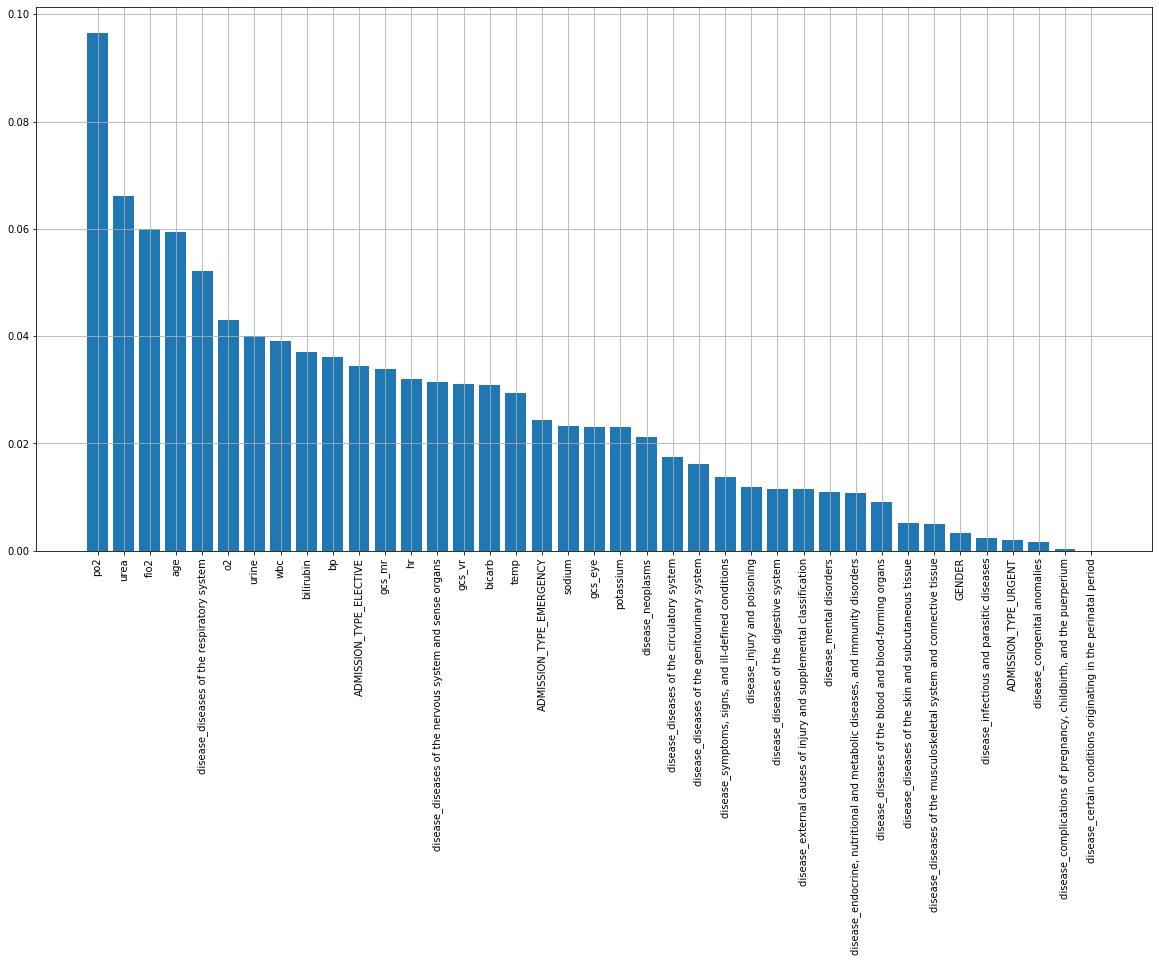

In [28]:
# RandomForest
rfc = RandomForestClassifier(max_depth=10, random_state=0)
rfc.fit(X_train, y_train)
importance = rfc.feature_importances_

fig, ax = plt.subplots(figsize=(20, 10))
a, b = zip(*sorted(zip(importance,feature_names), reverse=True))

ax.bar(b[:50], a[:50])
ax.set_xticklabels(labels = b[:50], rotation=90)
ax.grid()
# fig.savefig('plots/m_fi.png')

In [29]:
print(rfc.score(X_test, y_test))
print(rfc.score(X_train, y_train))
y_true = y_test
y_scores = rfc.predict_proba(X_test)[:, 1]

auroc = roc_auc_score(y_true, y_scores)
print(auroc)

0.7790901137357831
0.9009186351706037
0.8642357692116122


In [246]:
# LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

lr_score1 = lr.score(X_test, y_test)
lr_score2 = lr.score(X_train, y_train)
print(lr_score1)
print(lr_score2)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.883471837488458
0.897317512350524


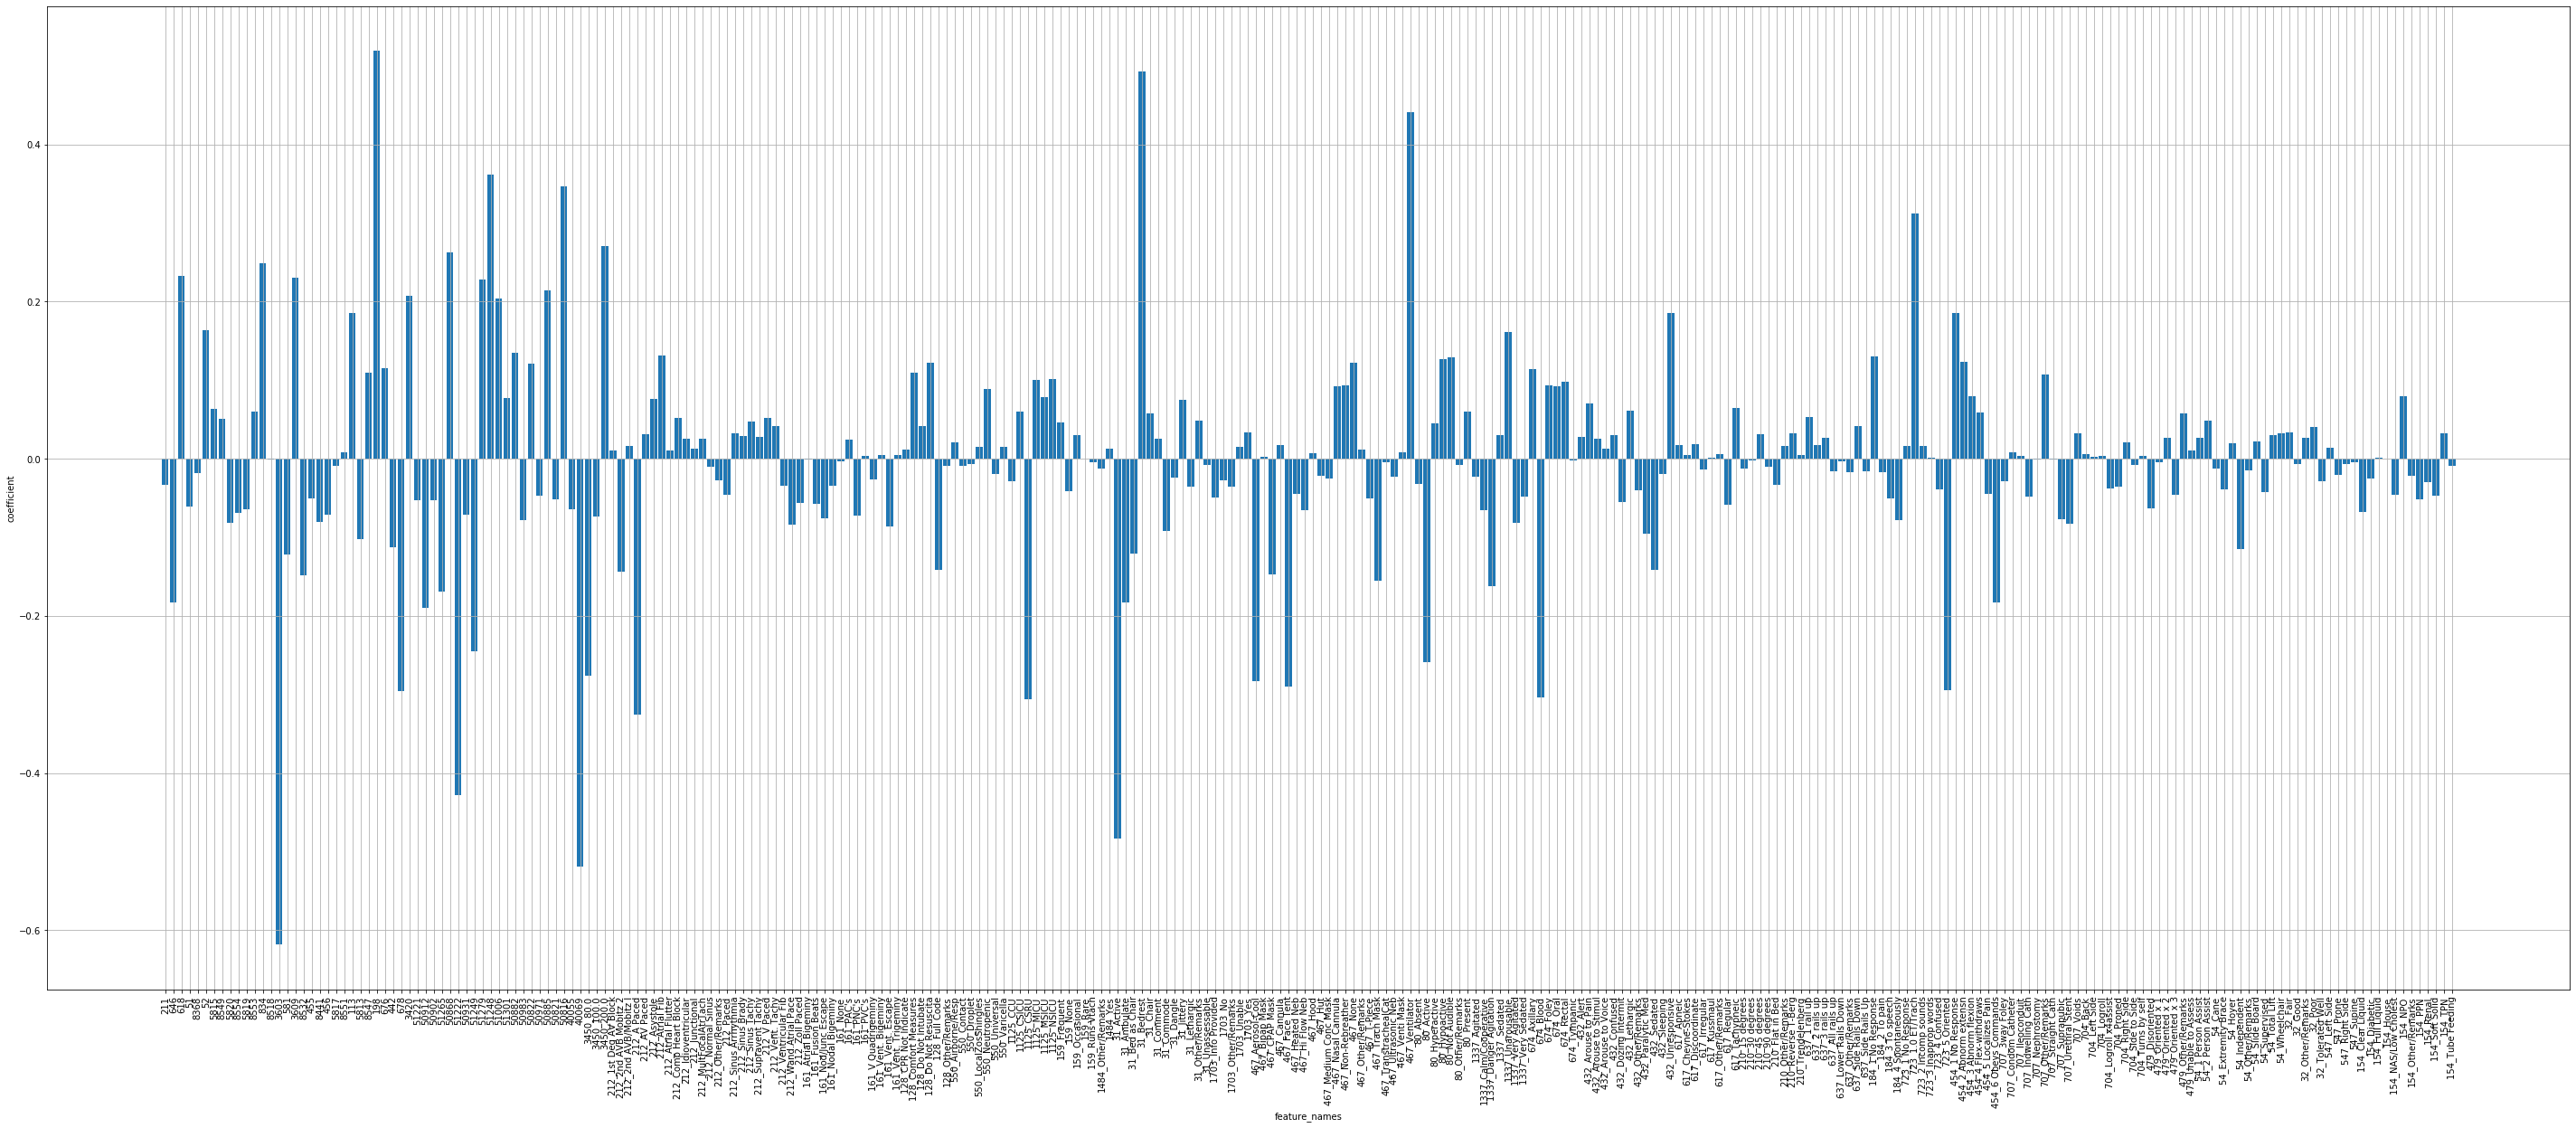

In [97]:
explain_logistic_regression(lr, feature_names)

Train on 7315 samples, validate on 1829 samples
Epoch 1/100
7315/7315 [==============================] - 1s 113us/step - loss: 0.6274 - accuracy: 0.6570 - val_loss: 0.5413 - val_accuracy: 0.7485
Epoch 2/100
7315/7315 [==============================] - 0s 38us/step - loss: 0.5441 - accuracy: 0.7303 - val_loss: 0.5073 - val_accuracy: 0.7583
Epoch 3/100
7315/7315 [==============================] - 0s 33us/step - loss: 0.5176 - accuracy: 0.7467 - val_loss: 0.4904 - val_accuracy: 0.7644
Epoch 4/100
7315/7315 [==============================] - 0s 34us/step - loss: 0.5056 - accuracy: 0.7548 - val_loss: 0.4790 - val_accuracy: 0.7616
Epoch 5/100
7315/7315 [==============================] - 0s 46us/step - loss: 0.4945 - accuracy: 0.7620 - val_loss: 0.4640 - val_accuracy: 0.7775
Epoch 6/100
7315/7315 [==============================] - 0s 33us/step - loss: 0.4815 - accuracy: 0.7673 - val_loss: 0.4576 - val_accuracy: 0.7802
Epoch 7/100
7315/7315 [==============================] - 0s 33us/step - los

7315/7315 [==============================] - 0s 34us/step - loss: 0.3592 - accuracy: 0.8395 - val_loss: 0.4361 - val_accuracy: 0.8081
Epoch 57/100
7315/7315 [==============================] - 0s 32us/step - loss: 0.3586 - accuracy: 0.8398 - val_loss: 0.4473 - val_accuracy: 0.8048
Epoch 58/100
7315/7315 [==============================] - 0s 32us/step - loss: 0.3559 - accuracy: 0.8463 - val_loss: 0.4416 - val_accuracy: 0.8092
Epoch 59/100
7315/7315 [==============================] - 0s 35us/step - loss: 0.3504 - accuracy: 0.8417 - val_loss: 0.4472 - val_accuracy: 0.8119
Epoch 60/100
7315/7315 [==============================] - 0s 32us/step - loss: 0.3457 - accuracy: 0.8439 - val_loss: 0.4470 - val_accuracy: 0.7993
Epoch 61/100
7315/7315 [==============================] - 0s 32us/step - loss: 0.3536 - accuracy: 0.8448 - val_loss: 0.4513 - val_accuracy: 0.8054
Epoch 62/100
7315/7315 [==============================] - 0s 31us/step - loss: 0.3414 - accuracy: 0.8498 - val_loss: 0.4552 - val_a

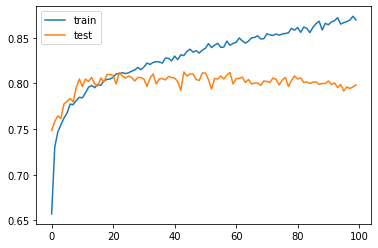

In [31]:
# Neural Network
m_model = Sequential()
m_model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
m_model.add(Dropout(0.2))
m_model.add(Dense(128, activation='relu'))
m_model.add(Dropout(0.2))
m_model.add(Dense(1, activation='sigmoid'))

m_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn = m_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=100)
nn_score = m_model.evaluate(X_test, y_test)
nn_score2 = m_model.evaluate(X_train, y_train)
print(nn_score[1])
print(nn_score2[1])
plt.plot(nn.history['accuracy'], label='train')
plt.plot(nn.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [38]:

y_true = y_test
y_scores = m_model.predict_proba(X_test)
y_pred = l_model.predict(X_test)


y_pred = np.round(y_pred)
y_pred = y_pred.flatten()
print(Counter(y_test))
print(Counter(y_pred))
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix: \n', cm)
auroc = roc_auc_score(y_true, y_scores)
print("AUROC: ", auroc)

Counter({0: 1181, 1: 1105})
Counter({1.0: 1401, 0.0: 885})
Confusion Matrix: 
 [[506 675]
 [379 726]]
AUROC:  0.8527086103118379


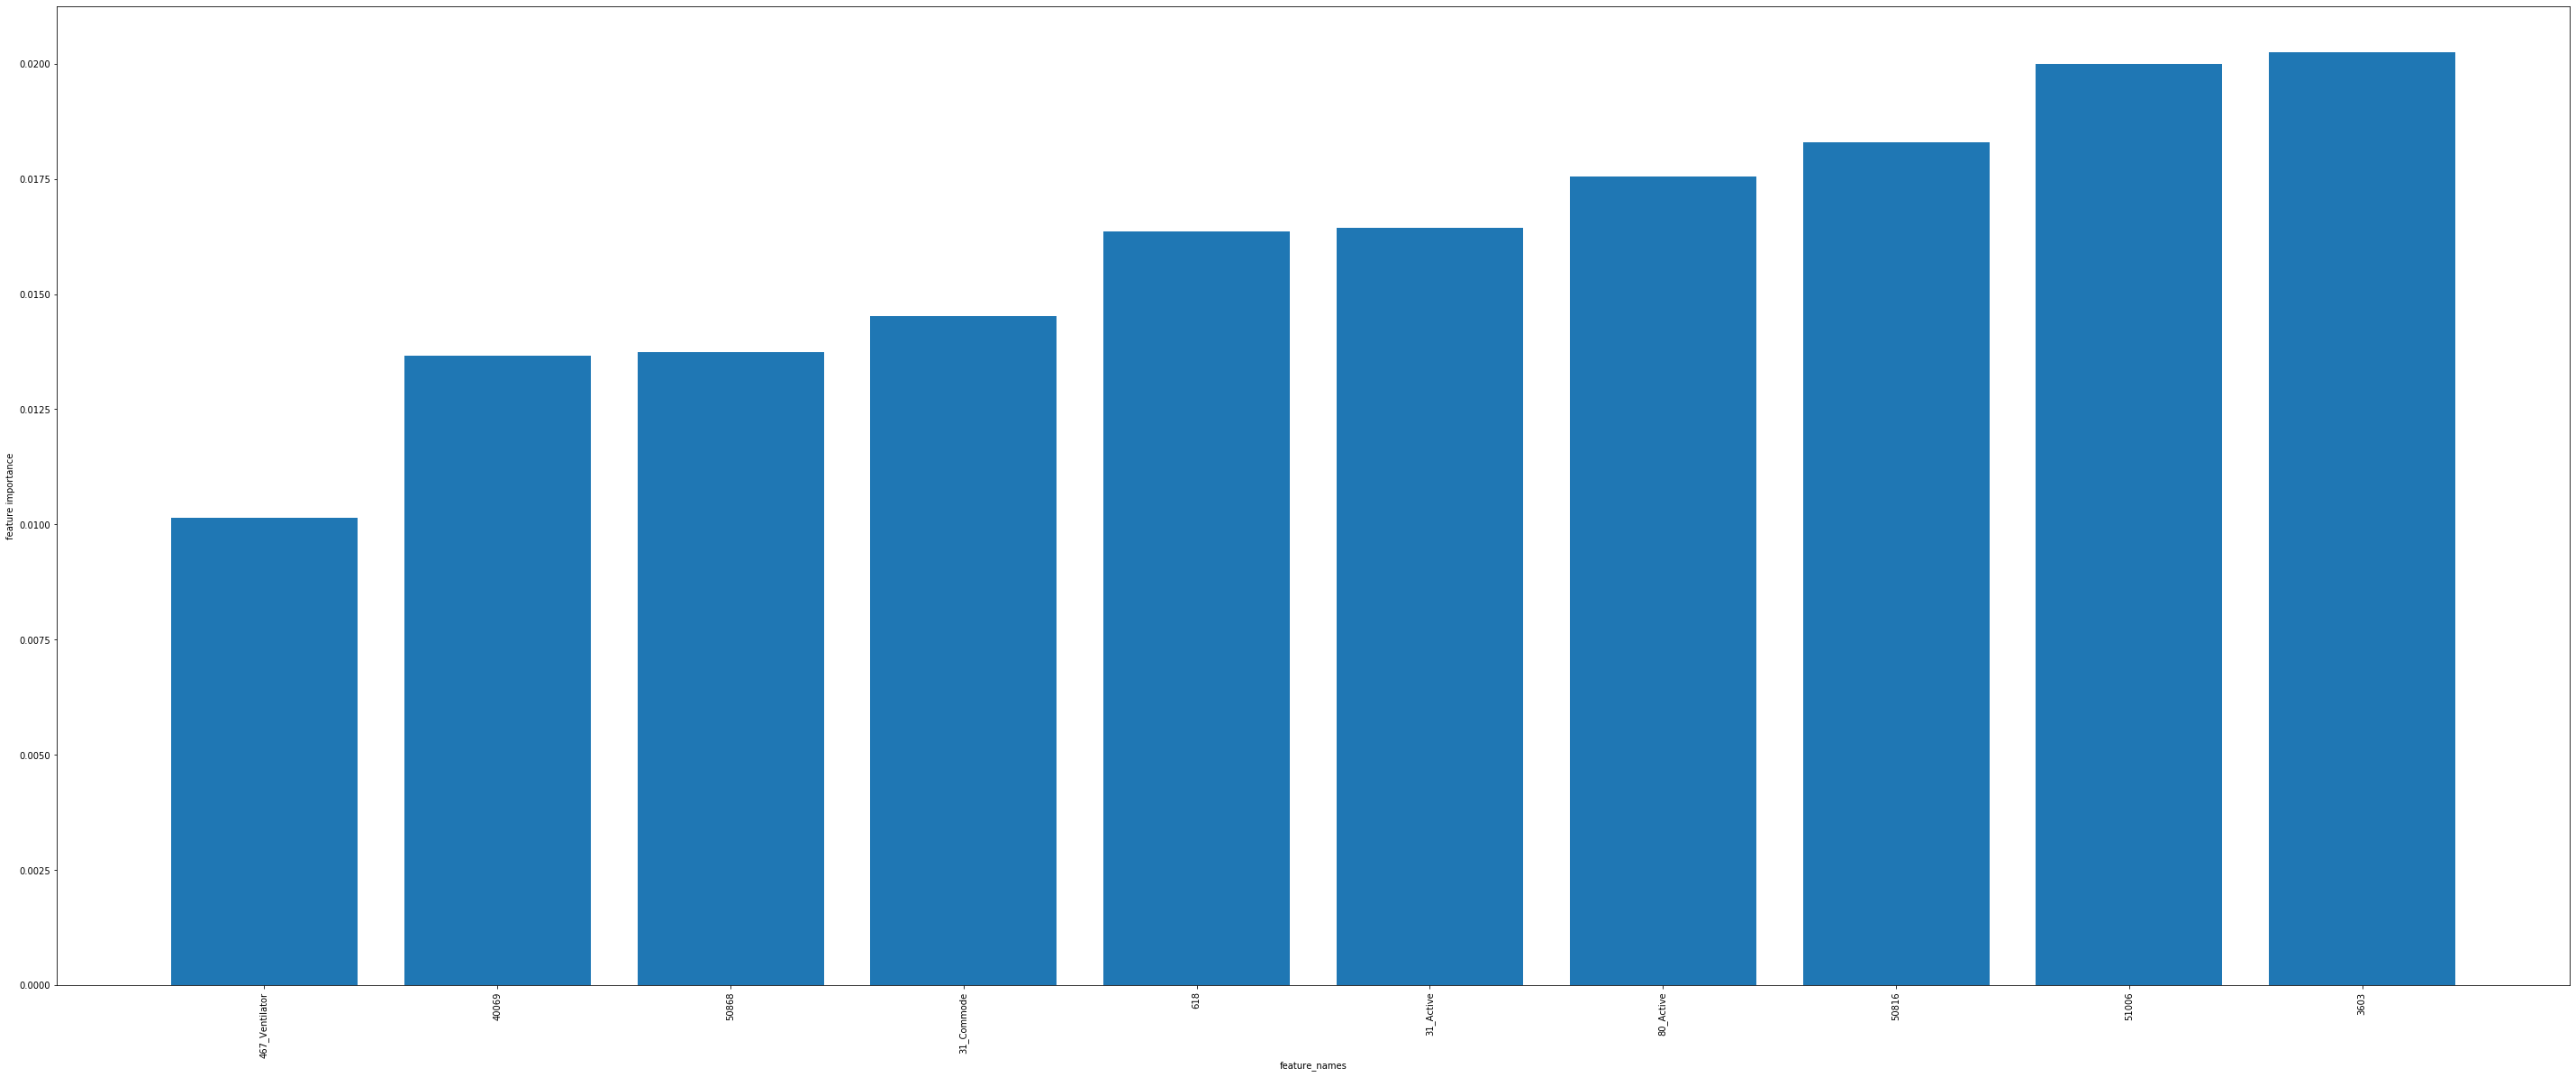

In [65]:
permutation_importance(m_model, feature_names, X_test, y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


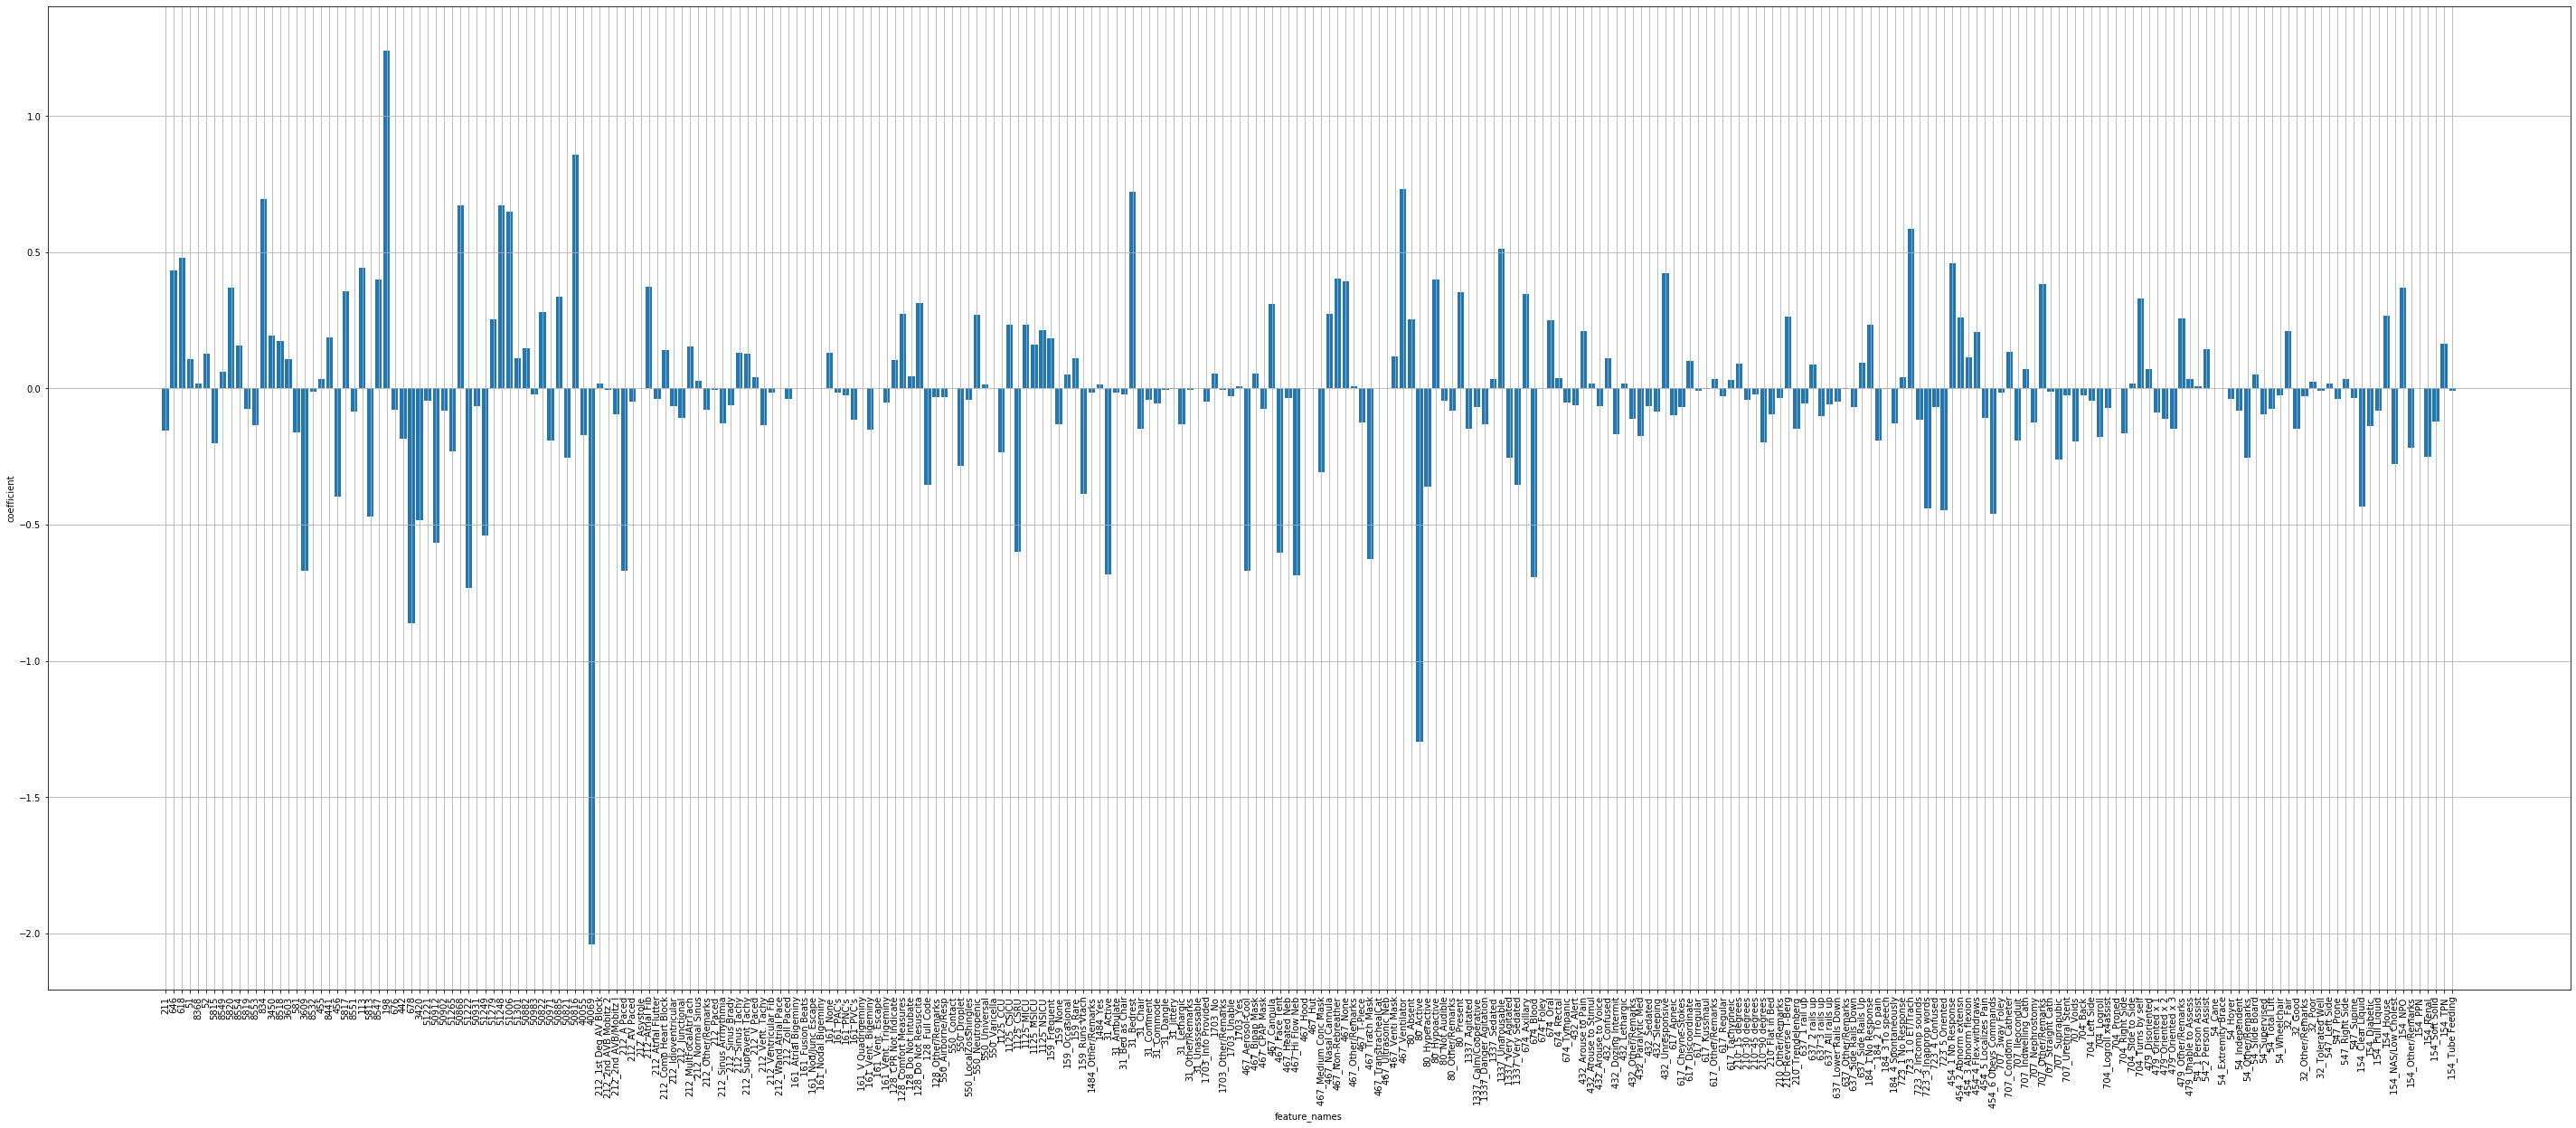

In [66]:
nn_y = m_model.predict(X_test)
nn_y[nn_y>0.5]=1
nn_y[nn_y<=0.5]=0

surrogate_nn = LogisticRegression(solver='newton-cg').fit(X_test, nn_y)
explain_logistic_regression(surrogate_nn, feature_names)